In [41]:
import pandas as pd
data = pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
data=data.loc[(data['SerlNo'] == 4419)]
data['measDate']=pd.to_datetime(data['measDate'])
data['Time'] = data['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
start_date=data['measDate'][0]
data['Week'] = data['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
result = data.groupby(['Week', 'Time'])['내부CO2'].mean().reset_index()
result['내부CO2'] = result['내부CO2'].round(1)
result



,Week,Time,내부CO2
0,1,Day,442.5
1,1,Night,507.3
2,2,Day,339.8
3,2,Night,400.9
4,3,Day,420.0
5,3,Night,465.8
6,4,Day,401.1
7,4,Night,456.4
8,5,Day,432.8
9,5,Night,485.4


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgunsl.ttf'


# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)

### 생육 정보 얹기

우선 2021년에 토마토를 기른 작기 ID를 불러오자

In [89]:
from src.api import SmartFarmAPI

api = SmartFarmAPI(config="config.yaml")
df = pd.DataFrame(api.crop_season.getCroppingSeasonDataList("2021"))
df_tomato = df[(df["itemName"] == "토마토") & (df["acqAutoYn"] == "Y")]
df_tomato_id=df_tomato['croppingSerlNo'].unique()
df_tomato_id


        상세 기능 번호  : 1
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기 정보 조회 
        
        * 요청 메세지 명세 *    
            year: 작기 시작 년도 String (형식 : yyyy)
            
        * 응답 메세지 명세 *
            facilityId: 시설 ID String 
            addressName: 지역명 String (법정동명)
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode       : 품목코드 String 
            itemName: 품목명 String
            croppingDate: 작기 시작 일자 String (형식 : yyyy-mm-dd)
            croppingEndDate: 작기 종료 일자 String (형식 : yyyy-mm-dd)
            acqAutoYn: 환경정보 등록 유무 String (Y : 등록, N : 미등록)
            acqManlYn: 제어정보 등록 유무 String (Y : 등록, N : 미등록)
            acqCultiYn: 생육정보 등록 유무 String (Y : 등록, N : 미등록)
            acqMgmtYn : 경영정보 등록 유무 String (Y : 등록, N : 미등록)
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


array([4419, 4420, 4430, 4431, 4514, 4425, 4504, 4423, 4957, 4549, 4557,
       4577, 4731, 4965, 4827, 4749, 4736, 4724, 4755, 4719, 4967, 5033,
       4922, 4791, 4796, 4828, 4744, 4800, 5041, 4753, 4751, 4730, 4857,
       4951, 4685, 4923, 4978, 4862, 4948, 4771, 4772, 4904, 4915, 4940,
       4908, 4925, 4757, 4941, 4860, 4769, 4809, 4839, 4905, 4919, 4760,
       4937, 4920, 4783, 4955, 4792, 4927, 4737, 4819, 4911, 4777, 4820,
       4817, 4953, 4980, 5038, 4971, 4952, 5035, 4934, 5031, 4732, 4918],
      dtype=int64)

그 중 맨 첫번째인 ID 4419의 생육정보를 가져온다. 

In [106]:
df=pd.DataFrame(api.crop_season.getCultivateDataList(4419))
df['examine_feature'] = df['examinIemNm'] + '(' + df['examinIemUnit'] + ')'
tomato_growth_info=df.drop(['examinIemNm','examinIemUnit'],axis=1)
tomato_growth_info['examinDe']=pd.to_datetime(tomato_growth_info['examinDe'])
tomato_growth_info


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


,statusCode,statusMessage,fcltyId,croppingSerlNo,itemCode,sampleNo,examinMasterSn,examinSn,examinDe,examinIemCode,examinIemValue,examine_feature
0,00,NORMAL_CODE,PF_0010071_01,4419,080600,1,31984,599110,2021-01-20,10000002,0.00,생장길이(mm)
1,None,None,PF_0010071_01,4419,080600,1,31984,599111,2021-01-20,10000008,0.00,화방높이(mm)
2,None,None,PF_0010071_01,4419,080600,1,31984,599112,2021-01-20,10000007,1.97,줄기직경(mm)
3,None,None,PF_0010071_01,4419,080600,1,31984,599113,2021-01-20,10000004,80.00,엽장(mm)
4,None,None,PF_0010071_01,4419,080600,1,31984,599114,2021-01-20,10000005,41.00,엽폭(mm)
...,...,...,...,...,...,...,...,...,...,...,...,...
955,None,None,PF_0010071_01,4419,080600,4,36256,770708,2021-06-30,10000003,10.00,엽수(개)
956,None,None,PF_0010071_01,4419,080600,4,36256,770709,2021-06-30,10000014,0.00,개화군(점)
957,None,None,PF_0010071_01,4419,080600,4,36256,770710,2021-06-30,10000015,2.00,착과군(점)
958,None,None,PF_0010071_01,4419,080600,4,36256,770711,2021-06-30,10000012,13.00,열매수(개)


미리 저장해놓은 2021년 모든 토마토 농가의 데이터셋을 불러온다.

In [99]:
import pandas as pd
raw_tomato = pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
df_sfecific=raw_tomato.loc[(raw_tomato['SerlNo'] == 4419)]
df_sfecific['measDate']=pd.to_datetime(df_sfecific['measDate'])
df_sfecific['Time'] = df_sfecific['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

start_date=df['measDate'][0]
#주차 계산
df_sfecific['Week'] = df_sfecific['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
mean_by_week = df_sfecific.groupby(['Week', 'Time'])['내부CO2'].mean().reset_index()
mean_by_week['내부CO2'] = mean_by_week['내부CO2'].round(1)
mean_by_week


C:\Users\mirun\AppData\Local\Temp\ipykernel_10148\2291121333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfecific['measDate']=pd.to_datetime(df_sfecific['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_10148\2291121333.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfecific['Time'] = df_sfecific['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
C:\Users\mirun\AppData\Local\Temp\ipykernel_10148\2291121333.py:9: SettingWithCopyWarning: 
A value is trying to be s

,Week,Time,내부CO2
0,1,Day,442.5
1,1,Night,507.3
2,2,Day,339.8
3,2,Night,400.9
4,3,Day,420.0
5,3,Night,465.8
6,4,Day,401.1
7,4,Night,456.4
8,5,Day,432.8
9,5,Night,485.4


In [122]:
tomato_growth_info_pivoted = tomato_growth_info.iloc[:].pivot_table(index='examinDe', columns='examine_feature', values='examinIemValue', aggfunc="mean")

first_examin_week=df_sfecific.loc[df_sfecific['measDate'].dt.date == tomato_growth_info_pivoted.index[0].date()]['Week'].iloc[0]
tomato_growth_info_pivoted['Week'] = range(first_examin_week, len(tomato_growth_info_pivoted)+first_examin_week)
tomato_growth_info_pivoted.set_index('Week', append=True, inplace=True)
tomato_growth_info_pivoted




,examine_feature,개화군(점),생장길이(mm),열매수(개),엽수(개),엽장(mm),엽폭(mm),줄기직경(mm),착과군(점),최종화방차수(차),화방높이(mm)
examinDe,Week,,,,,,,,,,
2021-01-20,2,0.0000,0.00,0.00,6.50,89.25,54.00,2.0850,0.0000,0.00,0.00
2021-01-27,3,0.0000,67.50,0.00,8.50,107.50,70.00,2.5850,0.0000,0.00,0.00
2021-02-03,4,0.0000,37.50,0.00,7.25,168.75,116.25,2.7800,0.0000,0.00,0.00
2021-02-09,5,0.0000,45.00,0.00,9.75,192.50,114.25,3.3625,0.0000,0.00,0.00
2021-02-17,6,0.0000,82.50,0.00,15.75,160.00,105.00,4.7850,0.0000,0.00,0.00
2021-02-24,7,0.1000,100.00,0.00,13.00,265.00,162.00,4.7600,0.0000,1.75,47.50
2021-03-03,8,0.3000,56.25,0.00,14.50,453.75,357.25,7.9425,0.0000,2.00,137.50
2021-03-10,9,0.4000,60.00,0.00,17.50,327.50,242.00,8.8775,0.0000,1.50,170.00
2021-03-17,10,1.0250,81.25,0.00,25.00,460.00,365.75,10.1725,0.1250,4.00,182.50


In [139]:
mean_by_week

,Week,Time,내부CO2
0,1,Day,442.5
1,1,Night,507.3
2,2,Day,339.8
3,2,Night,400.9
4,3,Day,420.0
5,3,Night,465.8
6,4,Day,401.1
7,4,Night,456.4
8,5,Day,432.8
9,5,Night,485.4


In [154]:
import seaborn as sns
font_path = 'C:/Windows/Fonts/malgunsl.ttf'

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# seaborn 스타일 설정
sns.set_style('white')

C:\Users\mirun\AppData\Local\Temp\ipykernel_10148\79278693.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tomato_farm_data.loc[-1] = {'Week': 1, '열매수(개)': 0}  # 1주차 데이터 추가
C:\Users\mirun\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mirun\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


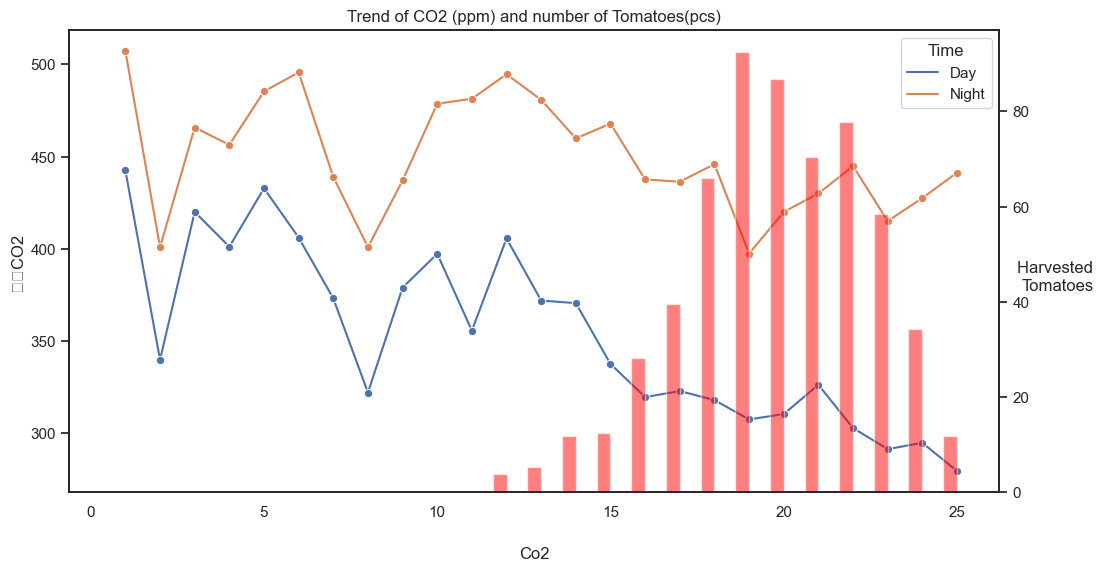

In [166]:


#draw a graph of the number of fruits by week and Co2 concentration by week
df_reset = tomato_growth_info_pivoted.reset_index()
tomato_farm_data=df_reset[['Week', '열매수(개)']]

tomato_farm_data.loc[-1] = {'Week': 1, '열매수(개)': 0}  # 1주차 데이터 추가
tomato_farm_data = tomato_farm_data.sort_index().reset_index(drop=True)

import matplotlib.pyplot as plt


# 그래프 사이즈 설정
plt.figure(figsize=(12, 6))

# 꺾은선 그래프 그리기
ax = sns.lineplot(data=mean_by_week, x="Week", y="내부CO2", hue="Time", marker="o")


# 막대 그래프 그리기를 위한 x 위치 설정
x = mean_by_week['Week'].unique()  # 주차 정보 가져오기
y = tomato_farm_data['열매수(개)'].values  # 열매 수 데이터 가져오기

# 두 번째 y축 (오른쪽) 설정
ax2 = ax.twinx()
# 막대 그래프 그리기 (주의: x 위치를 조정해야 할 수 있습니다.)
ax2.bar(x - 0.2, y, width=0.4, alpha=0.5, color='red') 

ax2.set_ylabel('Harvested \nTomatoes', rotation=0, labelpad=20)


# 그래프 제목 설정
plt.title('Trend of CO2 (ppm) and number of Tomatoes(pcs)')

plt.show()


In [144]:
tomato_farm_data

examine_feature,Week,열매수(개)
0,1,0.00
1,2,0.00
2,3,0.00
3,4,0.00
4,5,0.00
5,6,0.00
6,7,0.00
7,8,0.00
8,9,0.00
9,10,0.00
